# Chapter 4
    
    Created  : December 3rd 2020
    Notebook : April 18 2021

## Imports and preferences

In [1]:
import os
from functions.LunaUtils import *
import matplotlib.pyplot as plt
from functions.averaging import *
import matplotlib.font_manager as fm
sys.path.append('/Users/simonbelanger/Documents/UL/Silicon_Photonics/Python/CascadedMicroringFilter/')
sys.path.append('/Users/simonbelanger/Documents/UL/Silicon_Photonics/Python/ULPythonLab/data/')
from scipy.signal import find_peaks
import scipy.constants as cte
from misc.Filter import ringAnalyisGeneral
from matplotlib.patches import Rectangle
from scipy.signal import argrelextrema
from sweepobj import *
from components.MRF import *
from components.couplers.virtual_DC import virtual_DC
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Directory containing the datafiles and output directory for the pdfs
dataDirectory   = os.getcwd() + '/data.nosync/'
pdfDirectory    = '/Users/simonbelanger/Documents/UL/Silicon_Photonics/07_Thesis/ulthese.nosync/fig/chapter4/roadmData/'

# Import the font
fontLib         = '/Users/simonbelanger/Library/Fonts/'
overpassFont    = fm.FontProperties(family = 'Overpass', fname = fontLib+'overpass-semibold.otf', size = 12)

# Useful methods
def deltaNmToGHz(wvl_nm):
    return 1e-9 * np.abs(cte.c/1550e-9**2) * wvl_nm*1e-9

def deltaGHzToNm(f_GHz):
    return 1e9 * 1/np.abs(cte.c/1550e-9**2) * (f_GHz*1e9)

### 1) Calibration : PDL of the loopback structure 

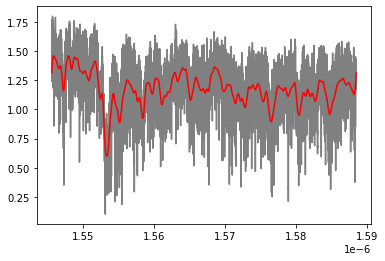

In [2]:
al = luna(dataDirectory + 'ALIGN.mat')
al.filter_bw      = 300 * 1e-12  # Bandwidth of the time domain filter, seconds [s]

plt.plot(al.read_param('wvl'), np.real(al.read_param('pdl')), color='grey')
plt.plot(al.read_param('wvl'), np.real(al.applySmoothingFilter(al.read_param('pdl'))), color='red')
plt.show()

### Graph #1 : 5 µm CROW, Insertion loss min/max and PDL on the same graph after tuning

#### Analytic modelling of the 5um filter

In [3]:
# Definition of the Analytic 5um and calculation of the transmission spectrum
kappa1, kappa2, kappa3 = sqrt(0.28), sqrt(0.0151), sqrt(0.0113)  # Paramètres de 02-10-2017
couplers    = [virtual_DC(kappa1, 1.), virtual_DC(kappa2, 1.),virtual_DC(kappa3, 1.),virtual_DC(kappa3, 1.),virtual_DC(kappa2, 1.),virtual_DC(kappa1, 1.)]
mrf         = MRF(num_rings=5, radius=5e-6, neff=2.365, ng=4.283087, alpha_wg=3.5, couplers=couplers, crosstalk_coeff=[1, 0., 0., 0., 0.])

# Calculation of the transmission using TMM
wvlNum5     = np.linspace(1550e-9, 1590e-9, 1000)
ilNum5      = 20*np.log10(mrf.TMM(wvlNum5, np.ones(len(wvlNum5))).drop)

# Analysis of the filter
raNum5      = ringAnalyisGeneral(wvlNum5, ilNum5)
cwNum5      = raNum5.measureLongitudinalModes('wavelength')


Finding peaks with an estimated height of = (-0.46230640687858204, -0.11557660171964551) dB ...


Finding peaks with an estimated prominence of = (59.50479163607487, 106.25855649299085) dB ...



# Figure 1 : 5um filter PDL

'overpass-semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


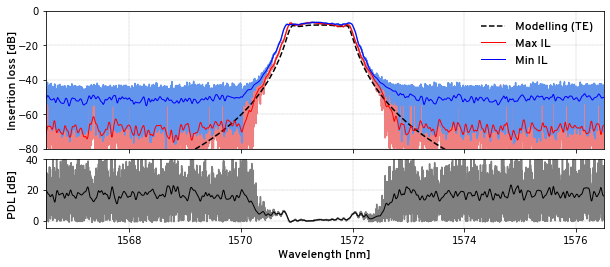

In [6]:
# Load the filter data
lm              = luna(dataDirectory + 'EC_DEV5_TUNED.mat')
lm.filter_bw    = 30 * 1e-12  # Bandwidth of the time domain filter, seconds [s]

# Plot the figure
fig, (topAx, botAx) = plt.subplots(figsize=(10, 4), nrows=2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
botAx.set_xlabel('Wavelength [nm]', font=overpassFont)
axCenter, axSpan = 1571.5, 10 # nm
botAx.set_xlim([axCenter-axSpan/2, axCenter+axSpan/2])
# top graph : Min/Max Insertion loss
topAx.plot(lm.read_param('wvl')*1e9, lm.read_param('min')-al.applySmoothingFilter(al.read_param('min')), color='lightcoral')
topAx.plot(lm.read_param('wvl')*1e9, lm.read_param('max')-al.applySmoothingFilter(al.read_param('max')), color='cornflowerblue')
topAx.plot(wvlNum5*1e9+4.54, 1+ilNum5+np.mean(al.applySmoothingFilter(al.read_param('min'))), linestyle='dashed', color='black',label='Modelling (TE)')
topAx.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('min'))-al.applySmoothingFilter(al.read_param('min')), linewidth=1, color='red', label='Max IL')
topAx.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('max'))-al.applySmoothingFilter(al.read_param('max')), linewidth=1, color='blue', label='Min IL')
topAx.grid(color='grey', linestyle='--', linewidth=0.25)
topAx.set_ylabel('Insertion loss [dB]', labelpad=0, font=overpassFont)
topAx.set_ylim([-80, 0])
topAx.legend(prop=overpassFont, frameon=False)
# bot graph : PDL
botAx.plot(lm.read_param('wvl')*1e9, lm.read_param('pdl')-al.applySmoothingFilter(al.read_param('pdl')), color='grey')
botAx.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('pdl'))-al.applySmoothingFilter(al.read_param('pdl')), linewidth=1, color='black')
botAx.grid(color='grey', linestyle='--', linewidth=0.25)
botAx.set_ylabel('PDL [dB]', labelpad=0, font=overpassFont)
botAx.set_ylim([-5, 40])
plt.subplots_adjust(hspace=.1)
fig.align_labels()
plt.savefig(pdfDirectory + 'roadm5um_pol.pdf')
plt.show()

### Characterization of the mean and std of the PDL in and out of band

In [7]:
#Calculate mean and std of the PDL in the passband (hardcoded)
calibratedPDL       = lm.read_param('pdl')-al.applySmoothingFilter(al.read_param('pdl'))
calibratedPDLrange  = calibratedPDL[np.where(np.logical_and(lm.read_param('wvl')>=1570.9e-9, lm.read_param('wvl')<=1571.9e-9))]
mean                = np.abs(np.mean(calibratedPDLrange))
std                 = np.abs(np.std(calibratedPDLrange))
print('In band\nmean \t= {:.3f} dB,\nstd \t= {:.3f} dB\n'.format(mean, std))
calibratedPDLrange  = calibratedPDL[np.where(lm.read_param('wvl')>=1570.9e-9)]
mean                = np.abs(np.mean(calibratedPDLrange))
std                 = np.abs(np.std(calibratedPDLrange))
print('Out of band\nmean \t= {:.3f} dB,\nstd \t= {:.3f} dB'.format(mean, std))

In band
mean 	= 0.424 dB,
std 	= 0.477 dB

Out of band
mean 	= 14.524 dB,
std 	= 12.130 dB


# Figure 2 : Insertion loss of the 2.5um variations


Finding peaks with an estimated height of = (-25.10330524993374, -6.275826312483435) dB ...


Finding peaks with an estimated height of = (-37.599984104425026, -9.399996026106257) dB ...


Finding peaks with an estimated height of = (-35.5608042036569, -8.890201050914225) dB ...


Finding peaks with an estimated height of = (-33.876534417655776, -8.469133604413944) dB ...



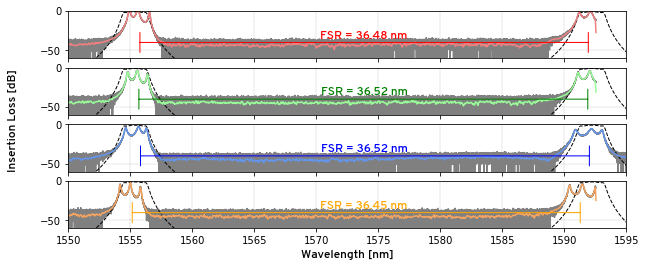

In [11]:
ILAdjust = 8.5 + 2.5*2 +1.5     # Loopback loss + 2 PSR (2.5 dB chq) + EL VOA (1.5 dB)
# Analytical response
kappa1,kappa2,kappa3 = sqrt(0.284), sqrt(0.0134), sqrt(0.0102)                      # Design Nominal SC_DP_EC_v5
couplers = [virtual_DC(kappa1, 1.),
            virtual_DC(kappa2, 1.),
            virtual_DC(kappa3, 1.),
            virtual_DC(kappa3, 1.),
            virtual_DC(kappa2, 1.),
            virtual_DC(kappa1, 1.)]
mrfAnal         = MRF(5, 2.5e-6, 2.383, 4.28, 30., couplers=couplers, crosstalk_coeff=[1, 0., 0., 0., 0.])
mrfAnal.clipping=False
wavelength      = np.linspace(1500e-9, 1600e-9, 1000)
outFieldsAnal   = mrfAnal.TMM(wavelength, np.ones(len(wavelength)))
#raAnal          = ringAnalyisGeneral(wavelength, 20*np.log10(outFieldsAnal.drop))
#cwAnal = raExp.measureLongitudinalModes('wavelength')
# Experimental response
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10, 4), nrows=4, sharex=True,sharey=True, gridspec_kw={'height_ratios': [1, 1, 1, 1]})
lm1              = luna(dataDirectory + 'EC_DEV1.mat')
lm2              = luna(dataDirectory + 'EC_DEV2.mat')
lm3              = luna(dataDirectory + 'EC_DEV3.mat')
lm4              = luna(dataDirectory + 'EC_DEV4.mat')
lm1.filter_bw    = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm2.filter_bw    = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm3.filter_bw    = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm4.filter_bw    = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
# Relative frequency plot
ra1 = ringAnalyisGeneral(lm1.read_param('wvl'), lm1.applySmoothingFilter(lm1.read_param('il')), peakFindingOptions={'estimateHeight': True, 'estimateProminence': False})      # Normalise the data using ringAnalysis (findpeaks)
ra2 = ringAnalyisGeneral(lm2.read_param('wvl'), lm2.applySmoothingFilter(lm2.read_param('il')), peakFindingOptions={'estimateHeight': True, 'estimateProminence': False})      # Normalise the data using ringAnalysis (findpeaks)
ra3 = ringAnalyisGeneral(lm3.read_param('wvl'), lm3.applySmoothingFilter(lm3.read_param('il')), peakFindingOptions={'estimateHeight': True, 'estimateProminence': False})      # Normalise the data using ringAnalysis (findpeaks)
ra4 = ringAnalyisGeneral(lm4.read_param('wvl'), lm4.applySmoothingFilter(lm4.read_param('il')), peakFindingOptions={'estimateHeight': True, 'estimateProminence': False})      # Normalise the data using ringAnalysis (findpeaks)
cw1, cw2, cw3, cw4 = ra1.measureLongitudinalModes('wavelength'), ra2.measureLongitudinalModes('wavelength'), ra3.measureLongitudinalModes('wavelength'), ra4.measureLongitudinalModes('wavelength')
ax1.plot(lm1.read_param('wvl')*1e9, ILAdjust+lm1.read_param('il'), color='grey')
ax2.plot(lm2.read_param('wvl')*1e9, ILAdjust+lm2.read_param('il'), color='grey') 
ax3.plot(lm3.read_param('wvl')*1e9, ILAdjust+lm3.read_param('il'), color='grey')
ax4.plot(lm4.read_param('wvl')*1e9, ILAdjust+lm4.read_param('il'), color='grey')
ax1.plot(wavelength*1e9, 20*np.log10(outFieldsAnal.drop), linewidth=1,linestyle='dashed', color='black')
ax2.plot(wavelength*1e9, 20*np.log10(outFieldsAnal.drop), linewidth=1,linestyle='dashed', color='black')
ax3.plot(wavelength*1e9, 20*np.log10(outFieldsAnal.drop), linewidth=1,linestyle='dashed', color='black')
ax4.plot(wavelength*1e9, 20*np.log10(outFieldsAnal.drop), linewidth=1,linestyle='dashed', color='black')
ax1.plot(lm1.read_param('wvl')*1e9, ILAdjust+lm1.applySmoothingFilter(lm1.read_param('il')), color='lightcoral')
ax2.plot(lm2.read_param('wvl')*1e9, ILAdjust+lm2.applySmoothingFilter(lm2.read_param('il')), color='palegreen') 
ax3.plot(lm3.read_param('wvl')*1e9, ILAdjust+lm3.applySmoothingFilter(lm3.read_param('il')), color='cornflowerblue')
ax4.plot(lm4.read_param('wvl')*1e9, ILAdjust+lm4.applySmoothingFilter(lm4.read_param('il')), color='sandybrown')
ax1.grid(color='grey', linestyle='--', linewidth=0.25)
ax2.grid(color='grey', linestyle='--', linewidth=0.25)
ax3.grid(color='grey', linestyle='--', linewidth=0.25)
ax4.grid(color='grey', linestyle='--', linewidth=0.25)
# Cannot measure FSR because the prominence is not sufficient
ax1.annotate(text='', xy=(cw1[1]*1e9,-40), xytext=(cw1[4]*1e9, -40), arrowprops=dict(arrowstyle='|-|', color='red'))
ax1.text((cw1[4]+cw1[1])*1e9/2, -35, s='FSR = {:.2f} nm'.format(np.abs(cw1[4]-cw1[1])*1e9), horizontalalignment='center', font=overpassFont, color='red')
ax2.annotate(text='', xy=(cw2[1]*1e9,-40), xytext=(cw2[5]*1e9, -40), arrowprops=dict(arrowstyle='|-|', color='green'))
ax2.text((cw1[4]+cw1[1])*1e9/2, -35, s='FSR = {:.2f} nm'.format(np.abs(cw2[5]-cw2[1])*1e9), horizontalalignment='center', font=overpassFont, color='green')
ax3.annotate(text='', xy=(cw3[1]*1e9,-40), xytext=(cw3[4]*1e9, -40), arrowprops=dict(arrowstyle='|-|', color='blue'))
ax3.text((cw1[4]+cw1[1])*1e9/2, -35, s='FSR = {:.2f} nm'.format(np.abs(cw3[4]-cw3[1])*1e9), horizontalalignment='center', font=overpassFont, color='blue')
ax4.annotate(text='', xy=(cw4[1]*1e9,-40), xytext=(cw4[4]*1e9, -40), arrowprops=dict(arrowstyle='|-|', color='orange'))
ax4.text((cw1[4]+cw1[1])*1e9/2, -35, s='FSR = {:.2f} nm'.format(np.abs(cw4[4]-cw4[1])*1e9), horizontalalignment='center', font=overpassFont, color='orange')
#ax.set_xlim([-5, 5])
ax4.set_xlim([1550, 1595])
ax1.set_ylim([-60, 0])
ax2.set_ylim([-60, 0])
ax3.set_ylim([-60, 0])
ax4.set_ylim([-60, 0])
ax4.set_xlabel('Wavelength [nm]', font=overpassFont)
fig.text(0.04, 0.5, 'Insertion Loss [dB]', va='center', rotation='vertical', font=overpassFont)
#plt.savefig(pdfDirectory + 'roadm25um_fsr.pdf')
plt.show()

# Figure 3 : Tuning of the 5um filter

In [7]:
%matplotlib qt
# Adjustments
ILAdjustNum    = 2.5*2 +1.5     # Loopback loss + 2 PSR (2.5 dB chq) + EL VOA (1.5 dB)
ajustment      = -0.12                 # to center the peak [nm] 
ILAdjust                = np.abs(np.mean(al.applySmoothingFilter(al.read_param('il'))))

# Get the data
lm5U                = luna(dataDirectory + 'EC_DEV5.mat')
lm5T                = luna(dataDirectory + 'EC_DEV5_TUNED.mat')
lm5U.filter_bw      = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm5T.filter_bw      = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]


# Plot the figure
fig, (leftAx, rightAx) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
leftAx.set_ylabel('Insertion loss [dB]', font=overpassFont)

# Left Ax : Tuning spectrum
leftAx.plot(lm5U.read_param('wvl')*1e9, ILAdjust+lm5U.applySmoothingFilter(lm5U.read_param('il')), color='grey', label='As-fabricated')
leftAx.plot(lm5T.read_param('wvl')*1e9, ILAdjust+lm5T.applySmoothingFilter(lm5T.read_param('il')), color='crimson', label='After tuning')
leftAx.set_xlim([1550, 1592])
leftAx.set_xlabel('Wavelength [nm]', font=overpassFont)
leftAx.grid(color='grey', linestyle='--', linewidth=0.25)
leftAx.legend(prop=overpassFont, frameon=False, loc='upper right', bbox_to_anchor=(0.92, 0.9))

# Right Ax : Relative wavelength
raU = ringAnalyisGeneral(lm5U.read_param('wvl'), ILAdjust+lm5U.applySmoothingFilter(lm5U.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
raT = ringAnalyisGeneral(lm5T.read_param('wvl'), ILAdjust+lm5T.applySmoothingFilter(lm5T.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
cwu, cwt = raU.measureLongitudinalModes('wavelength'), raT.measureLongitudinalModes('wavelength')
print(raT.measureLongitudinalModesOrder(2.4449, 5e-6))
rightAx.plot(lm5U.read_param('wvl')*1e9-cwu[2]*1e9, ILAdjust+lm5U.applySmoothingFilter(lm5U.read_param('il')), color='grey')
rightAx.plot(wvlNum5*1e9-cwNum5[1]*1e9, -ILAdjustNum+ilNum5, linestyle='dashed', color='black')    
rightAx.plot(lm5T.read_param('wvl')*1e9-cwt[1]*1e9+ajustment, ILAdjust+lm5T.applySmoothingFilter(lm5T.read_param('il')), color='crimson')    
rightAx.set_xlim([-3, 3])
rightAx.set_ylim([-60, 0])
rightAx.set_xlabel('Relative wavelength, ( $\lambda-\lambda_m$ ) [nm]', font=overpassFont)
rightAx.grid(color='grey', linestyle='--', linewidth=0.25)

# Second x axis
rightAxF = rightAx.secondary_xaxis('top', functions=(deltaNmToGHz, deltaGHzToNm))
rightAxF.set_xlabel('Relative frequency, ( $\\nu-\\nu_m$ ) [GHz]', font=overpassFont)

# Rectangle for inset
leftAx.add_patch(Rectangle((cwt[1]*1e9-4/2, leftAx.get_ylim()[0]), 4, leftAx.get_ylim()[1]-leftAx.get_ylim()[0], fill=None, linestyle='-.'))
plt.subplots_adjust(wspace=.1)
plt.savefig(pdfDirectory + 'roadm5um_tuning.pdf')
plt.show()


Finding peaks with an estimated height of = (-13.66817954797077, -3.4170448869926924) dB ...


Finding peaks with an estimated prominence of = (35.47096450971912, 63.34100805306986) dB ...


Finding peaks with an estimated height of = (-11.199061596361975, -2.799765399090494) dB ...


Finding peaks with an estimated prominence of = (35.38551912822964, 63.18842701469579) dB ...

[49. 49. 48.]


'overpass-semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


## Performances of the filters in the 3 cases 

IL, 3dB BW, 20dB BW, Ripples, FSR, etc

In [5]:
print('As-fabricated\r')
print('\tIL \t= {:.3f} dB\r'.format(raU.insertionLossDrop[2]))
print('\tBW3 \t= ({:.3f} nm, {:.3f} GHz)\r'.format(raU.measureBandwidth(-3)[2]*1e9, deltaNmToGHz(raU.measureBandwidth(-3)[2]*1e9)))
print('\tBW20 \t= ({:.3f} nm, {:.3f} GHz)\r'.format(raU.measureBandwidth(-20)[2]*1e9, deltaNmToGHz(raU.measureBandwidth(-20)[2]*1e9)))
print('\tOBRR \t= {:.3f} dB\r'.format(np.abs(raU.outOfBandRejectionRatio[2])))
print('\tFSR \t= {:.3f} nm\r'.format(np.squeeze(raU.freeSpectralRange[2])*1e9))

print('\r')
print('After tuning\r')
print('\tIL \t= {:.3f} dB\r'.format(raT.insertionLossDrop[1]))
print('\tBW3 \t= ({:.3f} nm, {:.3f} GHz)\r'.format(raT.measureBandwidth(-3)[1]*1e9, deltaNmToGHz(raT.measureBandwidth(-3)[1]*1e9)))
print('\tBW20 \t= ({:.3f} nm, {:.3f} GHz)\r'.format(raT.measureBandwidth(-20)[1]*1e9, deltaNmToGHz(raT.measureBandwidth(-20)[1]*1e9)))
print('\tOBRR \t= {:.3f} dB\r'.format(np.abs(raT.outOfBandRejectionRatio[1])))
print('\tFSR \t= {:.3f} nm\r'.format(np.squeeze(raT.freeSpectralRange[1])*1e9))

print('\r')
print('Simulated\r')
print('\tIL \t= {:.3f} dB\r'.format(raNum5.insertionLossDrop[0]-ILAdjustNum))
print('\tBW3 \t= ({:.3f} nm, {:.3f} GHz)\r'.format(raNum5.measureBandwidth(-3)[0]*1e9, deltaNmToGHz(raNum5.measureBandwidth(-3)[0]*1e9)))
print('\tBW20 \t= ({:.3f} nm, {:.3f} GHz)\r'.format(raNum5.measureBandwidth(-20)[0]*1e9, deltaNmToGHz(raNum5.measureBandwidth(-20)[0]*1e9)))
print('\tOBRR \t= {:.3f} dB\r'.format(np.abs(raNum5.outOfBandRejectionRatio[0])))
print('\tFSR \t= {:.3f} nm\r'.format(np.squeeze(raNum5.freeSpectralRange)*1e9))

As-fabricated
	IL 	= -7.470 dB
	BW3 	= (1.855 nm, 231.434 GHz)
	BW20 	= (11.414 nm, 1424.226 GHz)
	OBRR 	= 45.098 dB
	FSR 	= 18.309 nm

After tuning
	IL 	= -6.690 dB
	BW3 	= (1.732 nm, 216.104 GHz)
	BW20 	= (11.702 nm, 1460.165 GHz)
	OBRR 	= 45.699 dB
	FSR 	= 18.222 nm

Simulated
	IL 	= -6.731 dB
	BW3 	= (2.183 nm, 272.448 GHz)
	BW20 	= (5.487 nm, 684.699 GHz)
	OBRR 	= 79.316 dB
	FSR 	= 18.458 nm


In [ ]:
# Calcul de l'amplitude des ripples 
raNum5.

# Backup figures


Finding peaks with an estimated height of = (-31.31315759295188, -7.82828939823797) dB ...


Finding peaks with an estimated prominence of = (31.76181666582956, 56.71752976040993) dB ...


Finding peaks with an estimated height of = (-42.44245204265212, -10.61061301066303) dB ...


Finding peaks with an estimated prominence of = (28.08270033745045, 50.14767917401866) dB ...


Finding peaks with an estimated height of = (-39.39454514594061, -9.848636286485153) dB ...


Finding peaks with an estimated prominence of = (29.3948807217993, 52.490858431784474) dB ...


Finding peaks with an estimated height of = (-42.81674758911249, -10.704186897278122) dB ...


Finding peaks with an estimated prominence of = (28.224034017301168, 50.40006074518067) dB ...



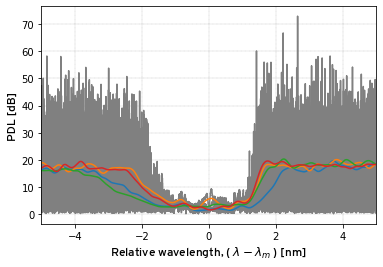

In [13]:
fig, ax = plt.subplots()
lm1              = luna(dataDirectory + 'EC_DEV1.mat')
lm2              = luna(dataDirectory + 'EC_DEV2.mat')
lm3              = luna(dataDirectory + 'EC_DEV3.mat')
lm4              = luna(dataDirectory + 'EC_DEV4.mat')
lm1.filter_bw    = 200 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm2.filter_bw    = 200 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm3.filter_bw    = 200 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm4.filter_bw    = 200 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
# Relative frequency plot
ra1 = ringAnalyisGeneral(lm1.read_param('wvl'), lm1.applySmoothingFilter(lm1.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
ra2 = ringAnalyisGeneral(lm2.read_param('wvl'), lm2.applySmoothingFilter(lm2.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
ra3 = ringAnalyisGeneral(lm3.read_param('wvl'), lm3.applySmoothingFilter(lm3.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
ra4 = ringAnalyisGeneral(lm4.read_param('wvl'), lm4.applySmoothingFilter(lm4.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
cw1, cw2, cw3, cw4 = ra1.measureLongitudinalModes('wavelength'), ra2.measureLongitudinalModes('wavelength'), ra3.measureLongitudinalModes('wavelength'), ra4.measureLongitudinalModes('wavelength')
plt.plot(lm1.read_param('wvl')*1e9-cw1[0]*1e9, lm1.read_param('pdl'), color='grey')
plt.plot(lm2.read_param('wvl')*1e9-cw2[0]*1e9, lm2.read_param('pdl'), color='grey')
plt.plot(lm3.read_param('wvl')*1e9-cw3[0]*1e9, lm3.read_param('pdl'), color='grey')
plt.plot(lm4.read_param('wvl')*1e9-cw4[0]*1e9, lm4.read_param('pdl'), color='grey')
plt.plot(lm1.read_param('wvl')*1e9-cw1[0]*1e9, lm1.applySmoothingFilter(lm1.read_param('pdl')))
plt.plot(lm2.read_param('wvl')*1e9-cw2[0]*1e9, lm2.applySmoothingFilter(lm2.read_param('pdl')))
plt.plot(lm3.read_param('wvl')*1e9-cw3[0]*1e9, lm3.applySmoothingFilter(lm3.read_param('pdl')))
plt.plot(lm4.read_param('wvl')*1e9-cw4[0]*1e9, lm4.applySmoothingFilter(lm4.read_param('pdl')))
ax.set_ylabel('PDL [dB]', font=overpassFont)
ax.set_xlabel('Relative wavelength, ( $\lambda-\lambda_m$ ) [nm]', font=overpassFont)
ax.grid(color='grey', linestyle='--', linewidth=0.25)
ax.set_xlim([-5, 5])
plt.show()

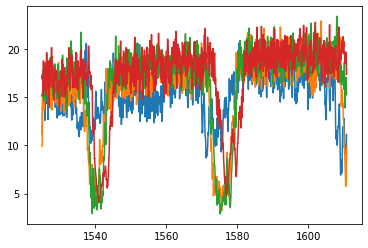

In [14]:

lm1                = luna(dataDirectory + 'DROP_CHANNEL1.mat')
lm2                = luna(dataDirectory + 'DROP_CHANNEL2.mat')
lm3                = luna(dataDirectory + 'DROP_CHANNEL3.mat')
lm4                = luna(dataDirectory + 'DROP_CHANNEL4.mat')
lm1.filter_bw      = 100 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm2.filter_bw      = 100 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm3.filter_bw      = 100 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm4.filter_bw      = 100 * 1e-12  # Bandwidth of the time domain filter, seconds [s]

#plt.plot(lm1.read_param('wvl')*1e9, lm1.applySmoothingFilter(lm1.read_param('min')))
#plt.plot(lm2.read_param('wvl')*1e9, lm2.applySmoothingFilter(lm2.read_param('min')))
#plt.plot(lm3.read_param('wvl')*1e9, lm3.applySmoothingFilter(lm3.read_param('min')))
#plt.plot(lm4.read_param('wvl')*1e9, lm4.applySmoothingFilter(lm4.read_param('min')))
#plt.plot(lm1.read_param('wvl')*1e9, lm1.applySmoothingFilter(lm1.read_param('max')))
#plt.plot(lm3.read_param('wvl')*1e9, lm3.applySmoothingFilter(lm3.read_param('max')))
#plt.plot(lm4.read_param('wvl')*1e9, lm4.applySmoothingFilter(lm4.read_param('max')))

# Phase
plt.plot(lm1.read_param('wvl')*1e9, lm1.applySmoothingFilter(lm1.read_param('pdl')))
plt.plot(lm2.read_param('wvl')*1e9, lm2.applySmoothingFilter(lm2.read_param('pdl')))
plt.plot(lm3.read_param('wvl')*1e9, lm3.applySmoothingFilter(lm3.read_param('pdl')))
plt.plot(lm4.read_param('wvl')*1e9, lm4.applySmoothingFilter(lm4.read_param('pdl')))
plt.show()

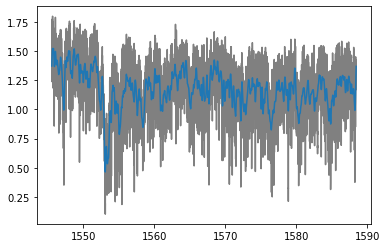

In [15]:
lm                = luna(dataDirectory + 'ALIGN.mat')
lm.filter_bw      = 100 * 1e-12  # Bandwidth of the time domain filter, seconds [s]

plt.plot(lm.read_param('wvl')*1e9, lm.read_param('pdl'), color='grey')
plt.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('pdl')))
plt.show()

Loading /Users/simonbelanger/Documents/UL/Silicon_Photonics/Python/CascadedMicroringFilter/thesis/chap4/data.nosync/scanFullRange.pickle ...


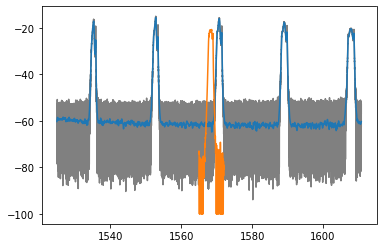

In [16]:
# Load OVA data
lm                = luna(dataDirectory + 'EC_DEV5.mat')
lm.filter_bw      = 100 * 1e-12  # Bandwidth of the time domain filter, seconds [s]

# Load Agilent TLS data
s1 = sweepobj(dataDirectory + 'scanFullRange')

# Produce the plot
plt.plot(lm.read_param('wvl')*1e9, lm.read_param('il'), color='grey')
plt.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('il')))
plt.plot(s1.wavelength*1e9, s1.detector_2)
plt.show()

Extracting Jones matrix...



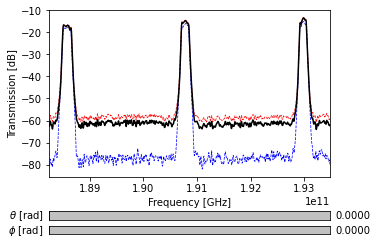

In [17]:
lm  = luna(dataDirectory + 'EC_DEV5_TUNED.mat')
lm.filter_bw      = 100 * 1e-12
lm.pol_gui()


Finding peaks with an estimated height of = (-0.46230640687858204, -0.11557660171964551) dB ...


Finding peaks with an estimated prominence of = (59.502780353027184, 106.25496491611997) dB ...


Finding peaks with an estimated height of = (-30.317049837947522, -7.5792624594868805) dB ...


Finding peaks with an estimated prominence of = (35.47096450971912, 63.34100805306986) dB ...


Finding peaks with an estimated height of = (-27.847931886338728, -6.961982971584682) dB ...


Finding peaks with an estimated prominence of = (35.38551912822964, 63.18842701469579) dB ...



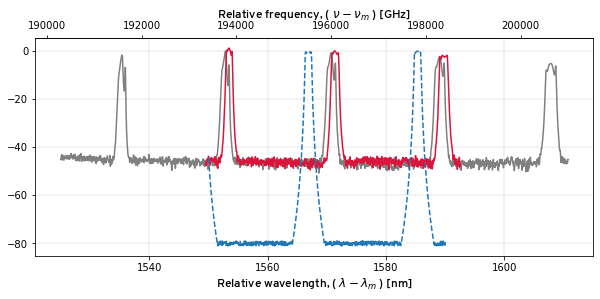

[18.45845846]
[17.50859325 17.8888703  18.3085265  18.85329296]
[17.86410074 18.22187492]


In [18]:
# Paramètres des figures du mémoire
kappa1,kappa2,kappa3 = sqrt(0.28), sqrt(0.0151), sqrt(0.0113)  # Paramètres de 02-10-2017
#kappa1,kappa2,kappa3 = 0.5, 0.07725769, 0.04293891             # Perfect Butterworth en field 
#kappa1,kappa2,kappa3 = 0.552, 0.156, 0.119                     # Design 3 EBeam - Optimal butterworth mais calculé en puissance donc erroné
#kappa1,kappa2,kappa3 = 0.552, 0.123, 0.106                      # Design Nominal SC_DP_EC_v5
couplers = [virtual_DC(kappa1, 1.), virtual_DC(kappa2, 1.),virtual_DC(kappa3, 1.),virtual_DC(kappa3, 1.),virtual_DC(kappa2, 1.),virtual_DC(kappa1, 1.)]
mrf = MRF(num_rings=5, radius=5e-6, neff=2.365, ng=4.283087, alpha_wg=3.5, couplers=couplers, crosstalk_coeff=[1, 0., 0., 0., 0.])
wavelength  = np.linspace(1565e-9, 1590e-9, 1000)
wavelength  = np.linspace(1550e-9, 1590e-9, 1000)
outFields   = mrf.TMM(wavelength, np.ones(len(wavelength)))
#mrf.plotTransmission(wavelength, outFields) 
raA = ringAnalyisGeneral(wavelength, 20*np.log10(outFields.drop))
cwa = raA.measureLongitudinalModes('wavelength')
#plt.plot(wavelength*1e9-cwa[2]*1e9, 20*np.log10(outFields.drop))
#plt.show()

ajustment = -0.12   # to center the peak [nm] 

lm5U                = luna(dataDirectory + 'EC_DEV5.mat')
lm5T                = luna(dataDirectory + 'EC_DEV5_TUNED.mat')
lm5U.filter_bw      = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]
lm5T.filter_bw      = 50 * 1e-12  # Bandwidth of the time domain filter, seconds [s]

# Calibration
ILAdjust = 3.5*2 + 2.5*2 + 1.5  # 2 PSR + 2 EC + 1 VOA
ILAdjust = 8.5 + 2.5*2 +1.5     # Loopback loss + 2 PSR (2.5 dB chq) + EL VOA (1.5 dB)

# Right Ax : Relative wavelength
raU = ringAnalyisGeneral(lm5U.read_param('wvl'), lm5U.applySmoothingFilter(lm5U.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
raT = ringAnalyisGeneral(lm5T.read_param('wvl'), lm5T.applySmoothingFilter(lm5T.read_param('il')))      # Normalise the data using ringAnalysis (findpeaks)
cwu, cwt = raU.measureLongitudinalModes('wavelength'), raT.measureLongitudinalModes('wavelength')
#-cwu[2]*1e9
#-cwt[1]*1e9+ajustment
#-cwa[0]*1e9

# Plotting functions
fig, Ax = plt.subplots(figsize=(10, 4))
Ax.plot(lm5U.read_param('wvl')*1e9, ILAdjust+lm5U.applySmoothingFilter(lm5U.read_param('il')), color='grey')
Ax.plot(lm5T.read_param('wvl')*1e9, ILAdjust+lm5T.applySmoothingFilter(lm5T.read_param('il')), color='crimson')    
Ax.plot(wavelength*1e9, 20*np.log10(outFields.drop), linestyle='dashed')
#Ax.set_xlim([-5, 5])
Ax.set_xlabel('Relative wavelength, ( $\lambda-\lambda_m$ ) [nm]', font=overpassFont)
Ax.grid(color='grey', linestyle='--', linewidth=0.25)
# Second x axis
AxF = Ax.secondary_xaxis('top', functions=(deltaNmToGHz, deltaGHzToNm))
AxF.set_xlabel('Relative frequency, ( $\\nu-\\nu_m$ ) [GHz]', font=overpassFont)
# Rectangle for inset
#plt.subplots_adjust(wspace=.1)
#plt.savefig(pdfDirectory + 'roadm5um_tuning.pdf')
plt.show()

# Mesure des proprietes des filtres untuned, tuned et analytique
print(np.asarray(raA.freeSpectralRange)*1e9)
print(np.asarray(raU.freeSpectralRange)*1e9)
print(np.asarray(raT.freeSpectralRange)*1e9)



Finding peaks with an estimated height of = (-2.978787514850797, -0.7446968787126993) dB ...


Finding peaks with an estimated prominence of = (55.656730377815535, 99.38701853181345) dB ...


Finding peaks with an estimated height of = (-0.337963014712307, -0.08449075367807675) dB ...


Finding peaks with an estimated prominence of = (53.387062162507576, 95.33403957590639) dB ...



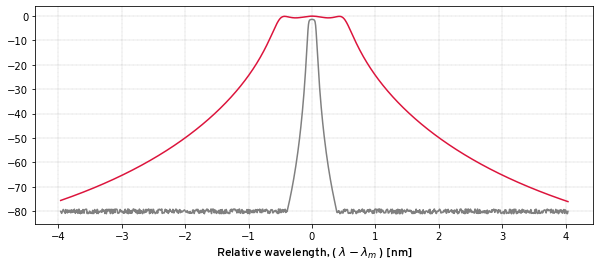

In [19]:

# Parametres
wavelength  = np.linspace(1575e-9, 1583e-9, 1000)
num_rings   = 5
radius      = 5e-6
neff        = 2.4449
ng          = 4.18
alpha_wg    = 3.

# Paramètres des figures du mémoire
kappa1,kappa2,kappa3 = 0.552, 0.123, 0.106                      # Design Nominal SC_DP_EC_v5
kappa1,kappa2,kappa3 = 0.2573153, 0.0204613, 0.0113721                      # Design Nominal SC_DP_EC_v5
couplers = [virtual_DC(kappa1, 1.),
            virtual_DC(kappa2, 1.),
            virtual_DC(kappa3, 1.),
            virtual_DC(kappa3, 1.),
            virtual_DC(kappa2, 1.),
            virtual_DC(kappa1, 1.)]
mrfExp = MRF(num_rings, radius, neff, ng, alpha_wg, couplers=couplers, crosstalk_coeff=[1, 0., 0., 0., 0.])
outFieldsExp   = mrfExp.TMM(wavelength, np.ones(len(wavelength)))
raExp = ringAnalyisGeneral(wavelength, 20*np.log10(outFieldsExp.drop))
cwExp = raExp.measureLongitudinalModes('wavelength')

mrfOpt = idealMRF(num_rings, radius, neff, ng, alpha_wg, powerCoupling=0.8**2, crosstalk_coeff=[1, 0., 0., 0., 0.])
outFieldsOpt   = mrfOpt.TMM(wavelength, np.ones(len(wavelength)))
raOpt = ringAnalyisGeneral(wavelength, 20*np.log10(outFieldsOpt.drop))
cwOpt = raExp.measureLongitudinalModes('wavelength')


fig, Ax = plt.subplots(figsize=(10, 4))
Ax.plot(wavelength*1e9-cwExp[0]*1e9, 20*np.log10(outFieldsExp.drop), color='grey')
Ax.plot(wavelength*1e9-cwOpt[0]*1e9, 20*np.log10(outFieldsOpt.drop), color='crimson')    
#Ax.set_xlim([-3, 3])
Ax.set_xlabel('Relative wavelength, ( $\lambda-\lambda_m$ ) [nm]', font=overpassFont)
Ax.grid(color='grey', linestyle='--', linewidth=0.25)
# Second x axis
#rightAxF = rightAx.secondary_xaxis('top', functions=(deltaNmToGHz, deltaGHzToNm))
#rightAxF.set_xlabel('Relative frequency, ( $\\nu-\\nu_m$ ) [GHz]', font=overpassFont)
# Rectangle for inset
#leftAx.add_patch(Rectangle((cwt[1]*1e9-4/2, leftAx.get_ylim()[0]), 4, leftAx.get_ylim()[1]-leftAx.get_ylim()[0], fill=None, linestyle='-.'))
plt.subplots_adjust(wspace=.1)
#plt.savefig(pdfDirectory + 'roadm5um_tuning.pdf')
plt.show()

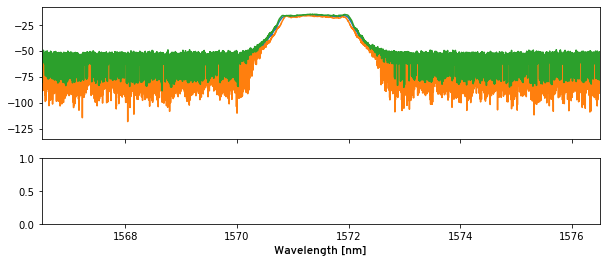

In [20]:
lm              = luna(dataDirectory + 'EC_DEV5_TUNED.mat')
lm.filter_bw    = 0 * 1e-12  # Bandwidth of the time domain filter, seconds [s]

fig, (topAx, botAx) = plt.subplots(figsize=(10, 4), nrows=2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
botAx.set_xlabel('Wavelength [nm]', font=overpassFont)
axCenter, axSpan = 1571.5, 10 # nm
botAx.set_xlim([axCenter-axSpan/2, axCenter+axSpan/2])
# top graph : Min/Max Insertion loss
topAx.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('il')))
topAx.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('min')))
topAx.plot(lm.read_param('wvl')*1e9, lm.applySmoothingFilter(lm.read_param('max')))
plt.show()